# **DCDC Práctica Final: Predicción de Stock<a id="top"></a>**

<i><small>**Alumnos:** Che Cui y Alejandro Pequeño<br>Última actualización: 15/01/2024</small></i></div>

---

**Índice:**

- [Imports](#-Imports)


- [1. Carga y visualización de datos](##-1.-Carga-y-visualización-de-datos)

<lr>

- [2. Análisis del DataFrame](##-2.-Análisis-del-DataFrame)
  - [2.1 Descomposición de la serie temporal](###-2.1-Descomposición-de-la-serie-temporal)
  - [2.2 Prueba de Dickey-Fuller](###-2.2-Prueba-de-Dickey-Fuller)
  - [2.3 Análisis de la autocorrelación](###-3.2-Análisis-de-la-autocorrelación)

<lr>

- [3. Métodos de Predicción](#-3.-Métodos-de-Predicción)
  - [3.0 AR, MA, ARMA](###-3.1-AR,-MA,-ARMA)
  - [3.1 ARIMA](###-3.1-ARIMA)
  - [3.2 SARIMA](###-3.2-SARIMA)
  - [3.3 SARIMAX](###-3.3-SARIMAX)

<lr>


## Imports

In [1]:
# Imports
# =====================================================================
!pip install statsmodels
import pandas as pd
import numpy as np
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

Defaulting to user installation because normal site-packages is not writeable


# Preparación de los datos

In [ ]:
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np

## Preparación de las noticias

El dataset proviene de Kaggle. En ella contiene alrededor de 41500 noticias francesas que van desde 2017-10-19 hasta 2021-03-19. Son scrapeado en paginas webs de noticias financieras famosas.

En este apartado lo que buscamos es quedarnos con solo las noticias y sus contenidos.

In [ ]:
news_french = pd.read_csv('data/FrenchNews.csv')

In [ ]:
news_french.head(10)

,Numero news,Numero page,Numero,Date,Heure,Titre,Contenu,Agency,URL,textURL,Nbr image,seconds to 2010,days to 2010,dateDT,Title eng,Content eng,textURL eng,Sentiment Vader Title,Sentiment Vader Text,Sentiment Vader TextURL
0,1,2127,18,19.10.2017,08:57,Marseille : une baleine de 15 mètres piégée da...,C'est une drôle de découverte qu'ont faite ce ...,Le Point,https://www.boursorama.com/actualite-economiqu...,C'est une drôle de découverte qu'ont faite ce ...,0,246099420.0,2848.372917,2017-10-19 08:57:00,Marseille: a 15 metre whale trapped in the Old...,This is a strange discovery that the Marseilla...,It's a strange discovery that the Marseillais ...,-0.5267,0.3612,0.8689
1,2,2127,17,19.10.2017,10:35,"Le Burkinabé qui a stoppé le désert, l'intox d...",L'émission de cette semaine nous emmène au Bur...,France 24,https://www.boursorama.com/videos/actualites/l...,L'émission de cette semaine nous emmène au Bur...,0,246105300.0,2848.440972,2017-10-19 10:35:00,"The Burkinabe who stopped the desert, the into...",This week's show takes us to Burkina Faso to m...,This week's show takes us to Burkina Faso to m...,-0.2263,-0.6486,-0.1531
2,3,2127,16,19.10.2017,10:59,"En Grande-Bretagne, les ventes au détail subis...",LONDRES (Reuters) - Les ventes au détail en Gr...,Reuters,https://www.boursorama.com/actualite-economiqu...,LONDRES (Reuters) - Les ventes au détail en Gr...,1,246106740.0,2848.457639,2017-10-19 10:59:00,"In Great Britain, retail sales stopped in Sept...",LONDON (Reuters) - Retail sales in Great Brita...,LONDON (Reuters) - Retail sales in Great Brita...,0.4939,0.3182,-0.4019
3,4,2127,15,19.10.2017,11:40,Antiterrorisme : Bruxelles fait avec les moyen...,La sécurité ne fait pas partie des prérogative...,Le Point,https://www.boursorama.com/actualite-economiqu...,La sécurité ne fait pas partie des prérogative...,0,246109200.0,2848.486111,2017-10-19 11:40:00,Anti-terrorism: Brussels made with the means o...,Security is not part of the European Union's p...,Security is not part of the European Union's p...,0.0000,0.3400,-0.9748
4,5,2127,14,19.10.2017,11:58,"Dmitri Rybolovlev, président de l'AS Monaco, i...","NICE (Reuters) - Le président de l'AS Monaco, ...",Reuters,https://www.boursorama.com/actualite-economiqu...,"NICE (Reuters) - Le président de l'AS Monaco, ...",1,246110280.0,2848.498611,2017-10-19 11:58:00,"Dmitri Rybolovlev, President of AS Monaco, cha...","NICE (Reuters) - The president of AS Monaco, D...","NICE (Reuters) - The president of AS Monaco, D...",-0.2023,-0.3954,0.9386
5,6,2127,13,19.10.2017,12:25,Amendes et gardes à vue pour les harceleurs de...,PARIS (Reuters) - Les agents de la police de s...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les agents de la police de s...,1,246111900.0,2848.517361,2017-10-19 12:25:00,"Fines and custody for street harassers, says C...",PARIS (Reuters) - The daily security police of...,PARIS (Reuters) - The officers of the daily se...,-0.5859,0.4767,0.5719
6,7,2127,12,19.10.2017,13:01,"En Californie, des vies réduites en cendres",6000. C'est le nombre de maisons qui ont été t...,France 24,https://www.boursorama.com/videos/actualites/e...,6000. C'est le nombre de maisons qui ont été t...,0,246114060.0,2848.542361,2017-10-19 13:01:00,"In California, lives reduced to ashes",6000. This is the number of houses that have b...,6000. This is the number of houses that have b...,0.0000,-0.7178,-0.8070
7,8,2127,11,19.10.2017,14:34,Les eurodéputés proposent d'interdire le glyph...,PARIS (Reuters) - Les députés européens de la ...,Reuters,https://www.boursorama.com/actualite-economiqu...,PARIS (Reuters) - Les députés européens de la ...,1,246119640.0,2848.606944,2017-10-19 14:34:00,MEPs propose banning glyphosate by 2020,PARIS (Reuters) - MEPs in the Committee on the...,PARIS (Reuters) - MEPs in the Committee on the...,0.0000,-0.7841,-0.7264
8,9,2127,10,19.10.2017,15:50,Fronde des policiers des stups : les magistrat...,"D'un côté, les policiers de l'Office central p..

In [ ]:
# nos quedamos con las columnas que nos interesan, que son las fechas y el contenido
news = news_french[['Date', 'Contenu']].copy()
# pasamos las fechas a formato datetime
news['Final_date'] = pd.to_datetime(news['Date'], format='%d.%m.%Y')
# drop de la columna date 
news.drop(['Date'], axis=1, inplace=True)

# renombramos las columnas para que sean más faciles de manejar
news.rename(columns={'Contenu': 'headline', 'Final_date': 'date'}, inplace=True)

In [ ]:
# miramos si hay algun valor nulo
news.isnull().sum()

headline    65
date         0
dtype: int64

In [ ]:
# eliminamos los valores nulos
news.dropna(inplace=True)

In [ ]:
# visualización de los datos
profile = ProfileReport(news, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# dataset final de las noticias
news

,headline,date
0,C'est une drôle de découverte qu'ont faite ce ...,2017-10-19
1,L'émission de cette semaine nous emmène au Bur...,2017-10-19
2,LONDRES (Reuters) - Les ventes au détail en Gr...,2017-10-19
3,La sécurité ne fait pas partie des prérogative...,2017-10-19
4,"NICE (Reuters) - Le président de l'AS Monaco, ...",2017-10-19
...,...,...
41538,Des véhicules de police aux vitres teintées ce...,2021-03-19
41539,Des voitures de police qui transporteraient le...,2021-03-19
41540,Les coiffeurs dans les zones concernées par un...,2021-03-19
41541,Focus sur la reconduction de la prime Macron p...,2021-03-19


## Preparación de los datos de los stocks

Con la ayuda de las librería de pandas-datareader e yfinance, es posible saca de manera facil desde Yahoo Finance los datos de los stock de manera facil y sencilla.

In [ ]:
#pip install pandas-datareader
#!pip install yfinance
from pandas_datareader import data as pdr
import yfinance as yfin
import sklearn.preprocessing as preprocessing

In [ ]:
# la fecha mínima y máxima de las noticias
min_date = news.date.min()
max_date = news.date.max()

In [ ]:
# resta 50 días a la fecha mínima( es importante ya que al predecir con las 25 fechas anteriores, necesitas esas 50 días de margen)
min_date = min_date - pd.DateOffset(days=50)
# suma 50 días a la fecha máxima
max_date = max_date + pd.DateOffset(days=50)

In [ ]:
# convertimos las fechas a string
min_date = min_date.strftime('%Y-%m-%d')
max_date = max_date.strftime('%Y-%m-%d')

In [ ]:
# datos del índice europeo
yfin.pdr_override()

euro = pdr.get_data_yahoo('^STOXX50E', start=min_date, end=max_date)


display(euro)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-30,3405.649902,3412.260010,3397.270020,3403.709961,3403.709961,23814000
2017-08-31,3409.620117,3437.820068,3409.620117,3421.469971,3421.469971,34738100
2017-09-01,3425.840088,3454.550049,3425.840088,3443.879883,3443.879883,26540900
2017-09-04,3436.360107,3438.060059,3419.060059,3430.419922,3430.419922,17726400
2017-09-05,3432.550049,3448.929932,3415.979980,3420.860107,3420.860107,27881800
...,...,...,...,...,...,...
2021-05-03,3979.500000,4009.729980,3965.500000,4000.250000,4000.250000,20815100
2021-05-04,4001.129883,4018.139893,3919.459961,3924.800049,3924.800049,35163600
2021-05-05,3927.290039,4003.090088,3927.290039,4002.790039,4002.790039,30131400


In [ ]:
# datos del índice francés
yfin.pdr_override()

french = pdr.get_data_yahoo('^FCHI', start=min_date, end=max_date)


display(french)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-30,5063.240234,5069.120117,5046.069824,5056.339844,5056.339844,61690100
2017-08-31,5083.120117,5104.779785,5068.439941,5085.589844,5085.589844,108192000
2017-09-01,5117.189941,5138.419922,5115.950195,5123.259766,5123.259766,75774600
2017-09-04,5088.279785,5114.700195,5088.279785,5103.970215,5103.970215,44171300
2017-09-05,5107.189941,5125.799805,5081.080078,5086.560059,5086.560059,72150200
...,...,...,...,...,...,...
2021-05-03,6285.509766,6314.919922,6252.660156,6307.899902,6307.899902,49980000
2021-05-04,6319.490234,6355.870117,6238.790039,6251.750000,6251.750000,85369200
2021-05-05,6284.540039,6339.470215,6275.140137,6339.470215,6339.470215,83862000


In [ ]:
# solo nos interesa predecir el valor de apertura
euro_open = euro[['Open']].copy()

In [ ]:
# reseteamos el índice
euro_open.reset_index(inplace=True)

In [ ]:
# normalizamos los datos para que estén entre 0 y 1
min_max_scaler = preprocessing.MinMaxScaler()
euro_open['Open'] = min_max_scaler.fit_transform(euro_open['Open'].values.reshape(-1,1))

In [ ]:
# datos final
euro_open

,Date,Open
0,2017-08-30,0.618192
1,2017-08-31,0.620606
2,2017-09-01,0.630469
3,2017-09-04,0.636865
4,2017-09-05,0.634548
...,...,...
919,2021-05-03,0.967111
920,2021-05-04,0.980263
921,2021-05-05,0.935366
922,2021-05-06,0.978178


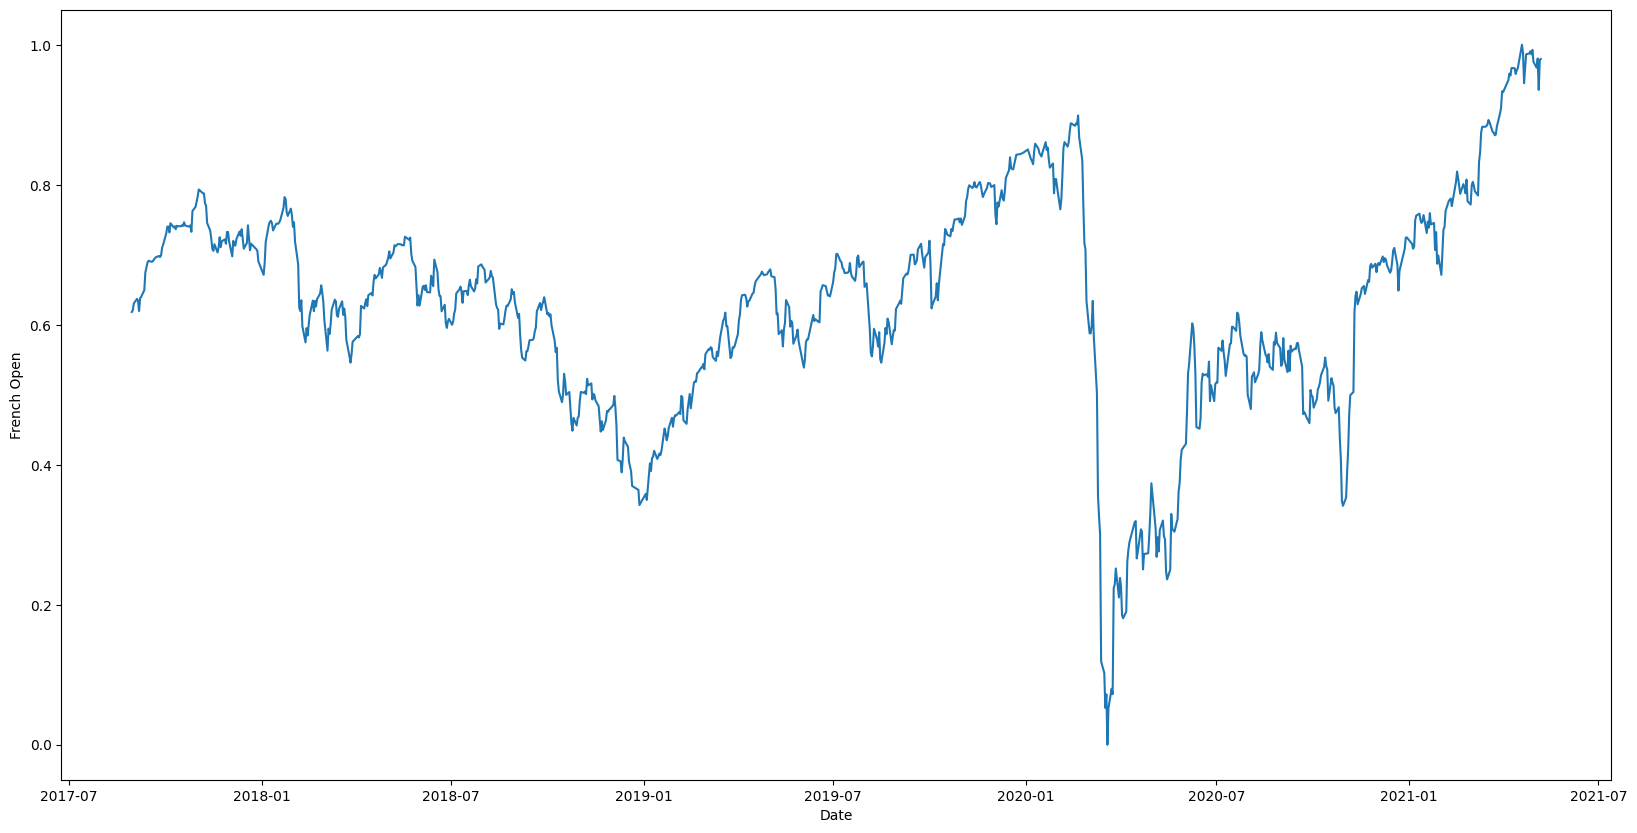

In [ ]:
# plot euro open using the date as x-axis

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(euro_open['Date'], euro_open['Open'])
plt.xlabel('Date')
plt.ylabel('French Open')
plt.savefig('euro_open.png')
plt.show()
# save the plot



In [ ]:
news

,headline,date
0,C'est une drôle de découverte qu'ont faite ce ...,2017-10-19
1,L'émission de cette semaine nous emmène au Bur...,2017-10-19
2,LONDRES (Reuters) - Les ventes au détail en Gr...,2017-10-19
3,La sécurité ne fait pas partie des prérogative...,2017-10-19
4,"NICE (Reuters) - Le président de l'AS Monaco, ...",2017-10-19
...,...,...
41538,Des véhicules de police aux vitres teintées ce...,2021-03-19
41539,Des voitures de police qui transporteraient le...,2021-03-19
41540,Les coiffeurs dans les zones concernées par un...,2021-03-19
41541,Focus sur la reconduction de la prime Macron p...,2021-03-19
